<a href="https://colab.research.google.com/github/DaviMartinsF/Deteccao-Box-Least-Square/blob/main/BLS_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightkurve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 4.4 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=d877fa7c3fc91f90e1333617a6db218d8be9b5823e00b639ff715d8974b57d3d
  Stored in directory: /root/.cache/pip/wheels/04/15/cd/2f6227

In [ ]:
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares
import numpy as np

# =============================================================================
# --- Lógica de Análise (Cálculo do BLS) ---
# =============================================================================

print("Rodando Célula 1: Carregamento de dados e Análise BLS...")

# === CONFIGURAÇÃO INICIAL ==================================================
alvo = "Kepler-7 b"
periodo_conhecido = 4.8854892
# =============================================================================

print(f"\n🔭 Analisando {alvo}")

try:
    # --- 1. BUSCA E PREPARAÇÃO DOS DADOS ---
    search = lk.search_lightcurve(alvo, author="Kepler", cadence="short")
    if len(search) == 0:
        print("ℹ️  Short cadence não encontrado; usando long cadence.")
        search = lk.search_lightcurve(alvo, author="Kepler", cadence="long")
    if len(search) == 0:
        raise RuntimeError("Nenhuma curva de luz encontrada para esse alvo.")

    print(f"Encontrados {len(search)} 'quarters'. Usando apenas o primeiro para a análise.")
    lc = search[0].download().remove_nans().normalize()
    time = lc.time.value
    flux = lc.flux.value

    # --- 2. ANÁLISE BLS (ENCONTRAR PARÂMETROS) ---
    bls = BoxLeastSquares(time, flux)

    # Definir durações para o BLS testar
    durations = np.linspace(0.05, 0.2, 50) # Testa 50 durações entre ~1h e ~5h

    print("Iniciando busca BLS (autopower)...")
    results = bls.autopower(durations, frequency_factor=5.0)
    print("Busca BLS concluída.")

    # --- 3. EXTRAIR PARÂMETROS E GERAR MODELO ---
    index = np.argmax(results.power)
    periodo_bls = results.period[index]
    t0_bls = results.transit_time[index]
    duracao_bls = results.duration[index]
    profundidade_bls = results.depth[index]

    print("\n✅ Parâmetros encontrados pelo BLS:")
    print(f"   - Período: {periodo_bls:.6f} dias")
    print(f"   - Época (t0): {t0_bls:.6f} BKJD")
    print(f"   - Duração: {duracao_bls:.4f} dias (~{(duracao_bls*24):.2f} horas)")
    print(f"   - Profundidade: {profundidade_bls:.4f}")

    # Gerar o modelo (necessário para os dois plots)
    modelo_ajustado = bls.model(time, periodo_bls, duracao_bls, t0_bls)

    print("\n✅ Variáveis prontas para os plots.")

except Exception as e:
    print(f"❌ Erro na Célula 1: {e}")

Rodando Célula 1: Carregamento de dados e Análise BLS...

🔭 Analisando Kepler-7 b
Encontrados 18 'quarters'. Usando apenas o primeiro para a análise.
Iniciando busca BLS (autopower)...
Busca BLS concluída.

✅ Parâmetros encontrados pelo BLS:
   - Período: 4.884265 dias
   - Época (t0): 261.303048 BKJD
   - Duração: 0.1850 dias (~4.44 horas)
   - Profundidade: 0.0068

✅ Variáveis prontas para os plots.



Rodando Célula 2: Gerando Plot 1 (Múltiplos Trânsitos)...


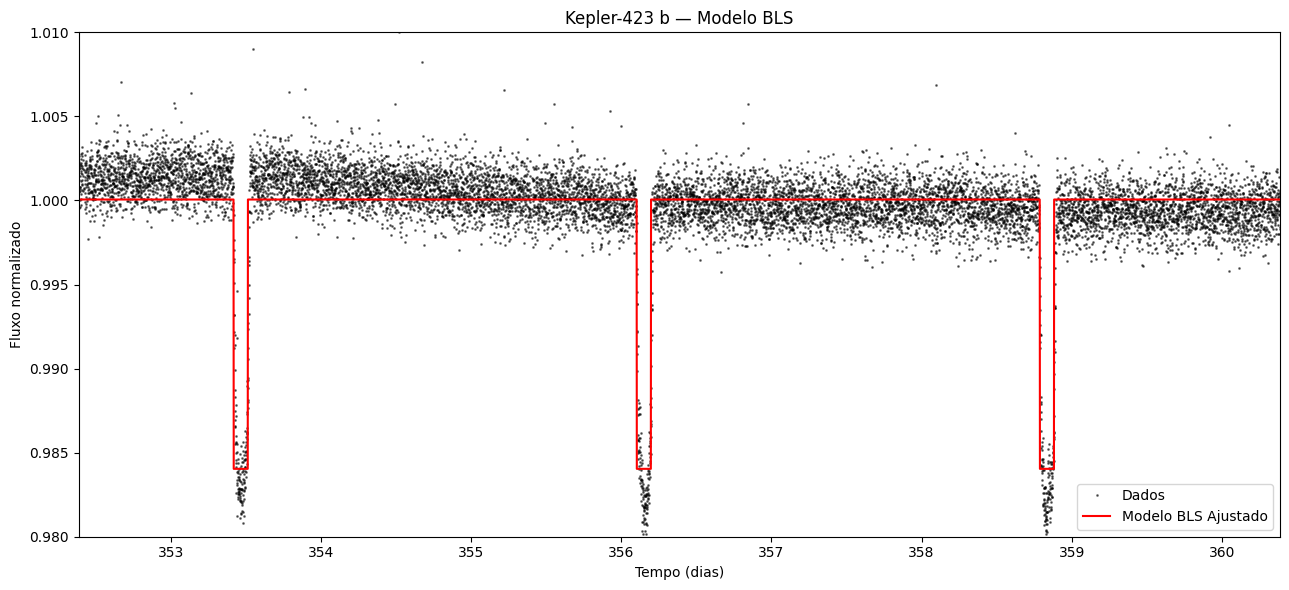

In [ ]:
try:
    print("\nRodando Célula 2: Gerando Plot 1 (Múltiplos Trânsitos)...")

    # --- PLOT 1: MÚLTIPLOS TRÂNSITOS (FOCADO) ---
    plt.figure(figsize=(13, 6))
    # Plotar os dados (pontos pretos)
    plt.plot(time, flux, "k.", markersize=2, alpha=0.5, label="Dados")
    # Plotar o modelo BLS encontrado (linha vermelha)
    plt.plot(time, modelo_ajustado, "r-", linewidth=1.5, label="Modelo BLS Ajustado")

    plt.title(f"{alvo} — Modelo BLS")
    plt.xlabel("Tempo (dias)")
    plt.ylabel("Fluxo normalizado")

    # Limites dos eixos (como você definiu)
    plt.ylim(0.98, 1.010)
    xlim_inicio = time.min()
    xlim_fim = xlim_inicio + 8
    plt.xlim(xlim_inicio, xlim_fim)

    plt.legend()
    plt.tight_layout()
    plt.show()

except NameError:
    print("❌ Erro: Variáveis não encontradas.")
except Exception as e:
    print(f"❌ Erro na Célula 2: {e}")


Rodando Célula 3: Gerando Plot 2 (Zoom no Trânsito)...


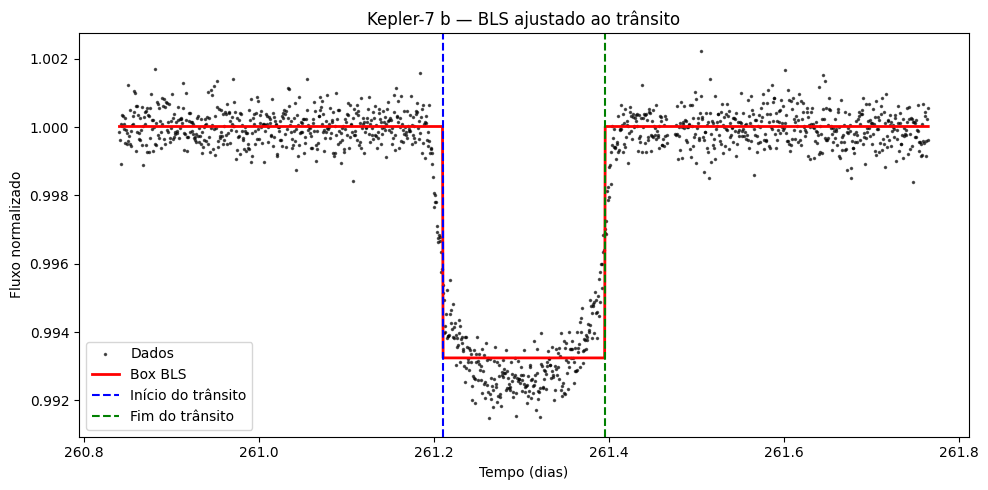

In [ ]:
try:
    print("\nRodando Célula 3: Gerando Plot 2 (Zoom no Trânsito)...")

    # --- PLOT 2: ZOOM NO TRÂNSITO ---
    # (Usa as variáveis t0_bls, duracao_bls, time, flux, etc. da Célula 1)
    janela = duracao_bls * 5
    mask = (time > (t0_bls - janela/2)) & (time < (t0_bls + janela/2))

    plt.figure(figsize=(10, 5))
    plt.plot(time[mask], flux[mask], "k.", markersize=3, alpha=0.6, label="Dados")
    # Plotar o novo modelo ajustado
    plt.plot(time[mask], modelo_ajustado[mask], "r-", linewidth=2, label="Box BLS")
    # Usar os novos parâmetros para as linhas de início/fim
    plt.axvline(t0_bls - duracao_bls/2, color="b", ls="--", label="Início do trânsito")
    plt.axvline(t0_bls + duracao_bls/2, color="g", ls="--", label="Fim do trânsito")

    plt.xlabel("Tempo (dias)")
    plt.ylabel("Fluxo normalizado")
    plt.title(f"{alvo} — BLS ajustado ao trânsito")
    plt.legend()
    plt.tight_layout()
    plt.show()

except NameError:
    print("❌ Erro: Variáveis não encontradas.")
except Exception as e:
    print(f"❌ Erro na Célula 3: {e}")